# Introduction

Here is a Jupyter Notebook (ipynb) of the Cell Dry Weight (CDW) and Fat in YAL media raman experiment from the T_Berger Master Thesis (2023)

On This Notebook you will find : 
 

*   The libraries and the main function used to prepared
*   The Experimental designal
*   The vizualization of the raw data / unoptimized and optimized preprocessing 
*   The PLS models built on all the data (raw /unoptimized preprocessed / optimized preprocessed) to predict the three target of interest (CDW/Fat) and the real bioprocess measurement used to test the model
*   The 4 CNN models built on all the data (raw /unoptimized preprocessed / optimized preprocessed) to predict the three target of interest (CDW/Fat) and the real bioprocess measurement used to test the model

3 Files with the 2 folders of experiments are needed to run the code correctly.

*   Medium_Cdw_fat.xlsx" (measurement/label file) / "Export_2D_CDWFat" (Raw_Raman_Spectrum in 2D of the related experiment) contained in a folder.

*   Real_Measure.xlsx" (measurement/label file) / "Bioprocess_2D" (Raw_Raman_Spectrum in 2D of the real bioprocess samples) contained in a folder for the CDW

*   Real_Measure_fat.xlsx" (measurement/label file) / "Oil_Measurements_Bioprocess_2D" (Raw_Raman_Spectrum in 2D of the real bioprocess samples) contained in a folder for the fat




# Preparation



## The libraries

To use the code in this notebook the following libraries have to be installed:

- pandas for importing our data and to process it
- numpy for use that data structure in the model and for lots of function
- sklearn will help us build a PLS model
- matplotlib for plotting the data
- tensorflow to build a ANN model such as the CNN(s)
- pybaseline to perform the baseline correction as a preprocessing step.
- if you want to use it on collab the google package is needed aswell as the dataset and the excel files (label of the measurments)


In [1]:
import os
import pandas as pd
import numpy as np
import random
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#from ipywidgets import interact, interactive, widgets, fixed, Layout

#from google.colab import drive
import tensorflow as tf

%matplotlib inline

In [2]:
#drive.mount('/content/drive')

In [3]:
#Installation of pybaselines
#!pip install pybaselines
import pybaselines.morphological as pymorph
import pybaselines.whittaker as pywh
import pybaselines.spline as pyspline
import pybaselines.smooth as pysmooth

## Data preparation functions

### Access to the files

In [4]:
from os import walk

def list_files(mpath):
  f = []
  for (dirpath, dirnames, filenames) in walk(mpath):
      f.extend(filenames)
      break
  return(f)

def triplicata(number,pos,path,dim=2):
  """
    List of the replicants of a specific file names containing the $dim dimensional sample of the file inside
    the folder with all the experiments results

    Parameters
    ----------
    number : string
        Specific experiment name ('21' for instance)

    pos : int
        Position of the first charcter of the name in the string (oftern 0)

    path : string
        Folder path containing the list of experiment 
      
    dim : int
        Dimension of the wanter raman spectra files / default 2

    Returns
    -------
    triplicat : List of string
        Files names of the specific files in the folder  
    
  """


  triplicat = []
  files = list_files(path)
  num = str(number)
  for f in files:
    f_ = f[pos:] 
    sh = f_.find('_')
    val = f[pos:sh]
    dim = str(dim)
    if val == num and f[-6] ==dim:
      triplicat.append(f)


  return triplicat

In [5]:

def list_files_2D(mpath,delete_):
    """ List of all the files containing the 2 dimensional sample file inside a folder 
    without the unwanted sample

    Parameters
    ----------
    mpath : string
        path of a folder containaing the spectra files

    delete_ : array like (list of string)
        list of the unwanted sample to be not listed

    Returns
    -------
    f : array like (list of string)
        list of name of wanted spectra 2D files inside a path    
    """
    files_2d = []
    files = list_files(mpath)
  
    for f in files :
        if f.endswith('.csv'):
            sh = f.find('_')
            val = f[0:sh]
            if f.endswith('2D.csv') and val not in delete_:
                files_2d.append(f)
    return(files_2d)

In [6]:
def list_files_specific(mpath,spec):
    """ List of all the files containing the wanted sample file inside a folder
    Parameters
    ----------
    mpath : string
        path of a folder containaing the spectra files

    spec : array like (list of string)
        list of the specific sample to be listed

    Returns
    -------
    f : array like (list of string)
        list of name of teh specific wanted spectra 2D files inside a path    
    """
    files_2d = []
    files = list_files(mpath)
    for f in files :
        if f.endswith('.csv'):
            sh = f.find('_')
            val = f[0:sh]
        if f.endswith('2D.csv') and val in spec:
            files_2d.append(f)
    return(files_2d)

def get_spectra_specific_file(mpath,spec):
    """ Get the wanted spectra data inside a folder 

    Parameters
    ----------
    mpath : string
        path of a folder containaing the spectra files

    spec : array like (list of string)
        list of the specific sample to be loaded

    Returns
    -------
    spectra_files : array like (list of pandas data frame)
        list of the spectra data of the specific samples.
    files_names : array like (list of string)
        list of name of wanted spectra 2D files inside a path    
    """
    files_names =list_files_specific(mpath,spec)
    spectra_files = [pd.read_csv(mpath + '/' + f, sep="\t", header=None, decimal=",") for f in files_names]
    return spectra_files,files_names

In [7]:
def get_spectra_files(mpath,delete_):
    """ Get all the spectra data data inside a folder without the unwanted sample

    Parameters
    ----------
    mpath : string
        path of a folder containaing the spectra files

    delete_ : array like (list of string)
        list of the unwanted sample to do not put in the dataset

    Returns
    -------
    spectra_files : array like (list of pandas data frame)
        list of the spectra data of the wanted samples.
    files_names : array like (list of string)
        list of name of wanted spectra 2D files inside a path    
    """
    files_names =list_files_2D(mpath,delete_)
    spectra_files = [pd.read_csv(mpath + '/' + f, sep="\t", header=None, decimal=",") for f in files_names]
    return spectra_files,files_names

### Preprocessing functions

Here are stored all the functions regarding the preprocessing step // For the unoptimized preprocessed and for the GA optimized preprocessed. It is possible to adds other functions from the process-spectra Library (on GitHub) by copy it to this section or directly include the function from the files on Github that contails the smoothing methods wanted. 


*   Cropping : 
*   Smoothing :
        SG_Filter
        Whittaker smoother


*   Baseline Correction : 
        Improve-AsLS
        Amormol


*   Normalization :
        SNV
        MSC (optional in our case)
        SNV_column












### Cropping

In [8]:
def crop_file(f, shift_lim):
    cropped_f = f[f[0]>=shift_lim[0]]
    cropped_f = cropped_f[cropped_f[0]<=shift_lim[1]]
    return cropped_f



### Smoothing

In [9]:
from scipy.signal import savgol_filter

def sg_filter(y, order, window):
    index_y =  y.index
    line = y[0]
    y = np.array(y[1])
    z = savgol_filter(y,window,order)
    z = pd.DataFrame(z,index = index_y, columns = [1] )
    z = pd.concat([line, z],axis =1,ignore_index = False)
    return z


In [10]:
def sg_filter_df(y, order, window):
    index_y =  y.index
    line = y[0]
    y = np.array(y[1])
    z = savgol_filter(y,window,order)
    z = pd.DataFrame(z,index = index_y, columns = [1] )
    z = pd.concat([line, z],axis =1,ignore_index = False)
    return z

In [11]:

def whittaker_smoother_df(y, lambda_whittaker, degree_whittaker):
    """Smooth data according to Whittaker.
    
    Parameters
    ----------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity to be smoothed
    lambda_whittaker : float
        smoothing parameter lambda
    degree_whittaker : int
        order of the penalty
    
    Returns
    -------
    z : pandas Dataframe
        [0] raman shift
        [1] smoothed intensity
        
    References
    ----------
    Eilers, P.H., 2003. A perfect smoother. Analytical chemistry, 75(14), pp.3631-3636.
    """   
    index_y =  y.index
    line = y[0]
    y = np.array(y[1])
    m = len(y)
    
    E = np.eye(m)
    D = np.diff(E, degree_whittaker)
    z = np.linalg.solve((E + lambda_whittaker*np.dot(D, D.T)),y)
    z = pd.DataFrame(z,index = index_y , columns = [1])
    z = pd.concat([line, z],axis =1,ignore_index = False)

    return z



### Baseline correction

In [12]:
def improved_asls(y,lambda_ias,penalty_ias,lambdaDer1_ias,max_iter_ias=100):
    """Perform baseline correction of data by applying an improve asymmetrical least squares (iasls) 
        for baseline fiiting using the iasls function from the pybaseline package

    Parameters
    ----------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity with baseline to be removed
    lambda_ias : float
        The smoothing parameter, Larger values will create smoother baselines.
    penalty_ias : 
        The penalizing weighting factor. Must be between 0 and 1.
    lambdaDer1_ias :
        The smoothing parameter for the first derivative of the residual
    max_iter_ias :
        The max number of fit iterations. Default is 50.
    Returns
    -------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity without baseline
    
    References
    ----------
    Martyna et al. 2020. Improving discrimation of Raman spectra by optimising 
        preprocessing strategies of the basis of the ability to refine the 
        relationship between variance components

    pybaseline package litterature : https://pybaselines.readthedocs.io/
    """
    index_y =  y.index
    line = y[0]
    data = y[1]
    x = np.array(y[1])
    ba, param = pywh.iasls(x,lam=lambda_ias,p=penalty_ias,lam_1=lambdaDer1_ias,max_iter=max_iter_ias)
    z = data-ba
    z = pd.DataFrame(z,index = index_y, columns = [1])
    z = pd.concat([line, z],axis =1,ignore_index = False)
    return z


In [13]:

def spline_arpls(y,lambda_spline_ar,knots_ar,spline_deg_ar,m_order_spline_ar=2):
    """Perform baseline correction of data by applying a penalized spline version of the
        Asymmetrically reweighted penalized least squares smoothing (arPLS) algorithm 
        for the baseline fiiting using the "pspline_arpls" function from the pybaseline package

    Parameters
    ----------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity with baseline to be removed
    
    lambda_spline_ar: float
        The smoothing parameter. Larger values will create smoother baselines

    knots_ar : int
        The number of knots for the spline

    spline_ar: int
        The degree of the spline (libear,cubic,quadratic)
    
    m_order_spline_ar : int
        The order of the differential matrix. Must be greater than 0. Default is 2
    
    Returns
    -------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity without baseline
    
    References
    ----------
    Martyna et al. 2020. Improving discrimation of Raman spectra by optimising 
        preprocessing strategies of the basis of the ability to refine the 
        relationship between variance components

    pybaseline package litterature : https://pybaselines.readthedocs.io/
    """
    index_y =  y.index
    line = y[0]
    data = y[1]
    k = np.array(y[0])
    x = np.array(y[1])
    ba, param = pyspline.pspline_arpls(x,lambda_spline_ar,knots_ar,spline_deg_ar,m_order_spline_ar,x_data = k)
    z = data-ba
    z = pd.DataFrame(z,index = index_y, columns = [1])
    z = pd.concat([line, z],axis =1,ignore_index = False)
    return z


### Normalization

In [14]:
def snv(input_datas):
    """
        :snv: A correction technique which is done on each
        individual spectrum, a reference spectrum is not
        required
        :param input_data: Array of spectral data
        :type input_data: DataFrame
        
        :returns: data_snv (ndarray): Scatter corrected spectra
    """

    comb = []
    input_data = []
    index_y = input_datas[0].index
  
    for i in range(len(input_datas)):
        comb.append(input_datas[i][0])
        input_data.append(input_datas[i][1])
    
    input_data = np.asarray(input_data)
    
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(data_snv.shape[0]):
    # Apply correction
      data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    
    data_fin_order = []
    for k in range(len(data_snv)):
      z = pd.DataFrame(data_snv[k],index = index_y , columns = [1])
      z = pd.concat([comb[k], z],axis =1,ignore_index = False)
      data_fin_order.append(z)
      
    
    
    
    return (data_fin_order)

In [15]:
def msc(input_datas, replicant,reference=None):
    """Scatter Correction technique performed with mean of the sample data as the reference.

    Parameters
    ----------
    input_datas : Array like of pandas dataframe (y) (order by the name of the sample)
                    [0] = raman_shift 
                    [1] = intensity to be 
        List of the raman spectra dataframe to be normalized
    
    replicants : int
        Number of replication measurement

    reference : panda dataframe (Default is None)
        [0] = raman_shift 
        [1] = intensity
        Reference spectra for the normalization ("BlanK")


    Returns
    -------
    output_data : Array like of pandas dataframe
                    [0] = raman_shift 
                    [1] = intensity normalized
        List of spectra dataframe normalized
    """
    comb = []
    input_data = []
    index_y = input_datas[0].index

    if reference is not None:
      input_ref = []
      for i in range(len(reference)):
        input_ref.append(reference[i][1])
      input_ref = np.array(input_ref, dtype=np.float64)


  
    for i in range(len(input_datas)):
        comb.append(input_datas[i][0])
        input_data.append(input_datas[i][1])
        
    eps = np.finfo(np.float32).eps
    input_data = np.array(input_data, dtype=np.float64)
    ref = []
    sampleCount = int(len(input_data))

    # Get the reference spectrum. If not given, estimate it from the mean
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    
    for i in range(input_data.shape[0]):
      if reference is None:
        if i%replicant == 0 and i != input_data.shape[0]-1:
          ref = np.mean(input_data[i:i+replicant], axis=0)
      else:
        ref = np.mean(input_ref[0:len(input_ref)],axis=0)
        # Run regression
      fit = np.polyfit(ref, input_data[i,:], 1, full=True)
      # Apply correction
      data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]
    data_fin_order = []
    for k in range(len(data_msc)):
      z = pd.DataFrame(data_msc[k],index = index_y , columns = [1])
      z = pd.concat([comb[k], z],axis =1,ignore_index = False)
      data_fin_order.append(z)


    return (data_fin_order)
    

In [16]:
def snv_col(input_datas):
    """
        :snv: A correction technique which is done on each
        individual spectrum, a reference spectrum is not
        required
        :param input_data: Array of spectral data
        :type input_data: DataFrame
        
        :returns: data_snv (ndarray): Scatter corrected spectra
    """

    comb = []
    input_data = []
    index_y = input_datas[0].index
  
    for i in range(len(input_datas)):
        comb.append(input_datas[i][0])
        input_data.append(input_datas[i][1])
    
    input_data = np.asarray(input_data)
    
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(data_snv.shape[1]):
    # Apply correction
      data_snv[:,i] = (input_data[:,i] - np.mean(input_data[:,i])) / np.std(input_data[:,i])
    
    data_fin_order = []
    for k in range(len(data_snv)):
      z = pd.DataFrame(data_snv[k],index = index_y , columns = [1])
      z = pd.concat([comb[k], z],axis =1,ignore_index = False)
      data_fin_order.append(z)
    
    
    
    return (data_fin_order)

# The Experimental Design

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


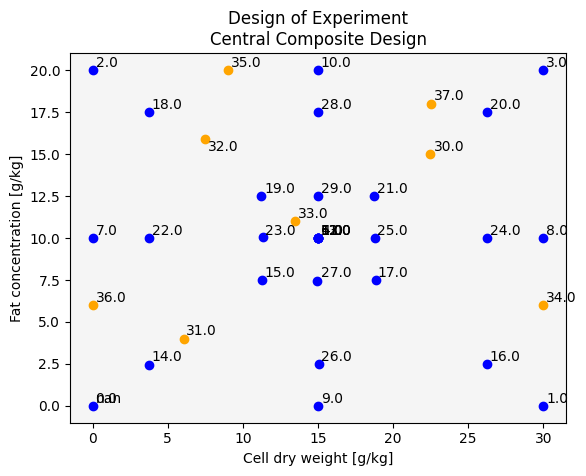

In [17]:
from mpl_toolkits.mplot3d import Axes3D

#drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/RamanCDW'
file_path = os.getcwd()
sample_overview = pd.read_excel(file_path + "/Medium_Cdw_fat.xlsx", sheet_name="Samples")




train_X = sample_overview[sample_overview["Is for training"]==1]["Cell dry weight [g/kg]"]
train_Y = sample_overview[sample_overview["Is for training"]==1]["Fat Acid concentration [g/kg]"]
test_X = sample_overview[sample_overview["Is for training"]==0]["Cell dry weight [g/kg]"]
test_Y = sample_overview[sample_overview["Is for training"]==0]["Fat Acid concentration [g/kg]"]

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(train_X, train_Y,c = 'b')
ax.scatter(test_X, test_Y,c = 'orange')
ax.set_xlabel("Cell dry weight [g/kg]")
ax.set_ylabel("Fat concentration [g/kg]")
ax.set_title("Design of Experiment\nCentral Composite Design")
ax.set_facecolor("whitesmoke")


for idx in sample_overview.index:
    ax.text(
        sample_overview["Planned cell dry weight [g/kg]"][idx]+0.2,
        sample_overview["Planned Fat Acid concentration [g/kg]"][idx]+0.2,
        sample_overview["Sample"][idx]
    )


# Visualization

## Raw Data

### Replications

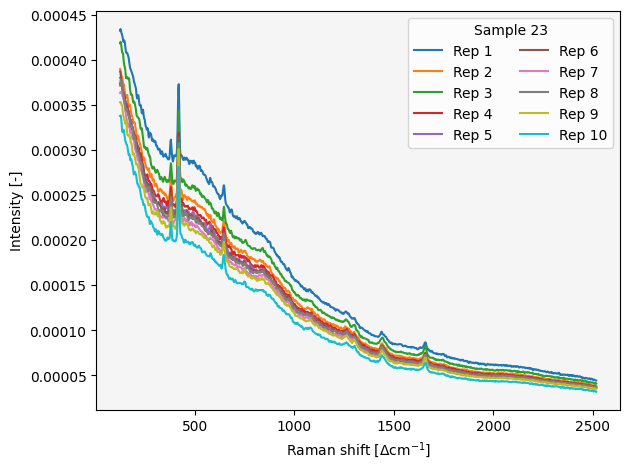

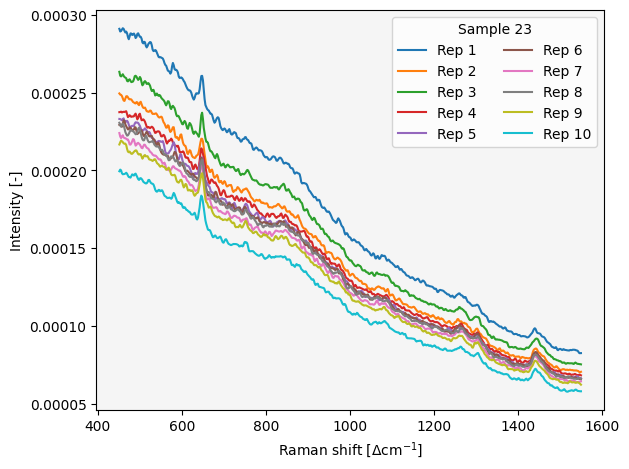

In [18]:
my_data = file_path + "/Export_2D_CDWFat"
experiment_wanted = ['23']
file_names = list_files_specific(my_data,experiment_wanted)
files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names]

shift_lim = [450, 1550]
cropped_files = [crop_file(f, shift_lim) for f in files]


raw_fig, raw_ax = plt.subplots()
for f in files:
    raw_ax.plot(f[0], f[1])
raw_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
raw_ax.set_ylabel("Intensity [-]")
raw_ax.legend(["Rep 1", "Rep 2", "Rep 3","Rep 4","Rep 5","Rep 6","Rep 7","Rep 8","Rep 9","Rep 10"], title="Sample 23",ncol=2)
raw_ax.set_facecolor("whitesmoke")

plt.tight_layout()

crop_fig, crop_ax = plt.subplots()
for f in cropped_files:
    crop_ax.plot(f[0], f[1])
crop_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
crop_ax.set_ylabel("Intensity [-]")
crop_ax.legend(["Rep 1", "Rep 2", "Rep 3","Rep 4","Rep 5","Rep 6","Rep 7","Rep 8","Rep 9","Rep 10"], title="Sample 23",ncol=2)
crop_ax.set_facecolor("whitesmoke")

plt.tight_layout()

### CDW concentration

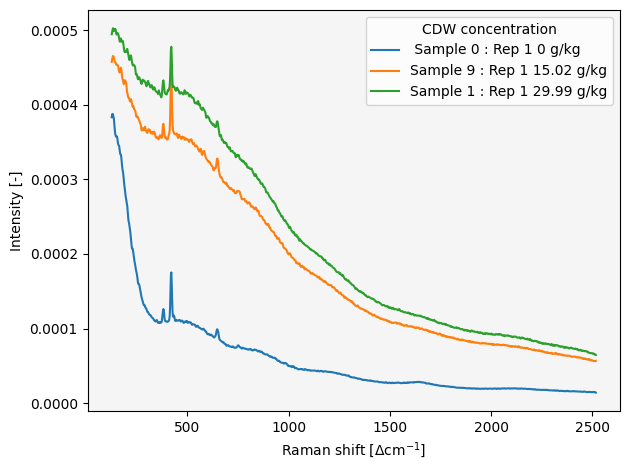

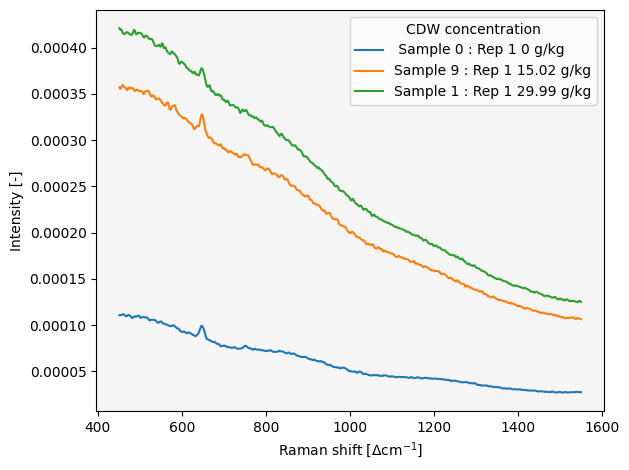

In [19]:
my_data = file_path + "/Export_2D_CDWFat"
#experiment_wanted = '23'
#file_names = triplicata(experiment_wanted,0,my_data,2)
file_names = ['0_254_2D.csv','9_294_2D.csv','1_144_2D.csv']
#file_names = ['0_254_2D.csv','7_134_2D.csv','2_326_2D.csv']
files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names]

experiment_wanted = '0'
file_names_ref = triplicata(experiment_wanted,0,my_data,2)
files_ref = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names_ref]

shift_lim = [450, 1550]
cropped_files = [crop_file(f, shift_lim) for f in files]
cropped_files_ref = [crop_file(f, shift_lim) for f in files_ref]


raw_fig, raw_ax = plt.subplots()
for f in files:
    raw_ax.plot(f[0], f[1])
raw_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
raw_ax.set_ylabel("Intensity [-]")
raw_ax.set_facecolor("whitesmoke")
raw_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 9 : Rep 1 15.02 g/kg", "Sample 1 : Rep 1 29.99 g/kg"], title="CDW concentration")
plt.tight_layout()

crop_fig, crop_ax = plt.subplots()
for f in cropped_files:
    crop_ax.plot(f[0], f[1])
crop_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
crop_ax.set_ylabel("Intensity [-]")
crop_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 9 : Rep 1 15.02 g/kg", "Sample 1 : Rep 1 29.99 g/kg"], title="CDW concentration")
crop_ax.set_facecolor("whitesmoke")

plt.tight_layout()

### Fat concentrations

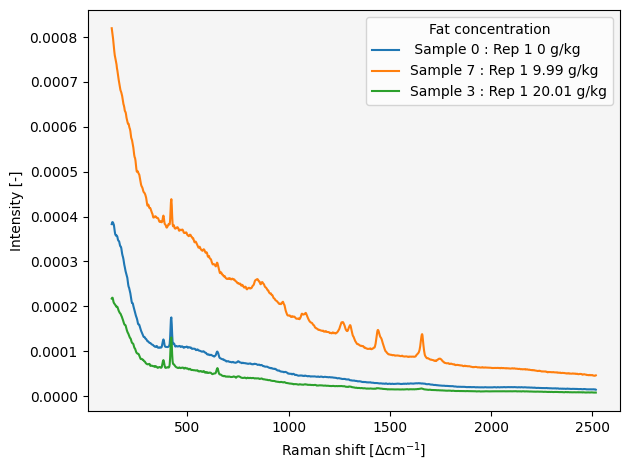

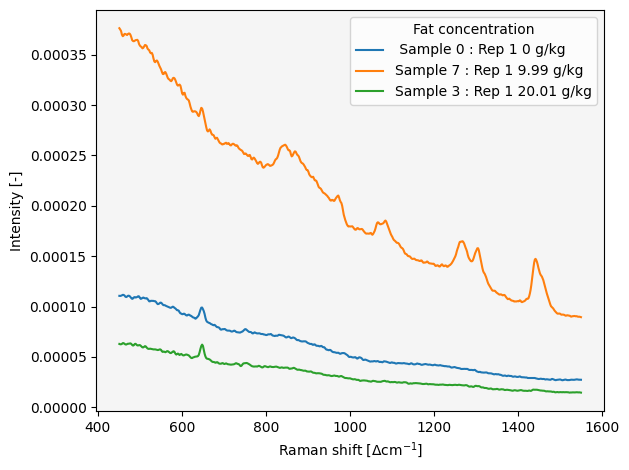

In [20]:
my_data = file_path + "/Export_2D_CDWFat"
#experiment_wanted = '23'
#file_names = triplicata(experiment_wanted,0,my_data,2)
#file_names = ['0_254_2D.csv','9_294_2D.csv','1_144_2D.csv']
file_names = ['0_254_2D.csv','7_134_2D.csv','2_326_2D.csv']
files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names]

experiment_wanted = '0'
file_names_ref = triplicata(experiment_wanted,0,my_data,2)
files_ref = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names_ref]

shift_lim = [450, 1550]
cropped_files = [crop_file(f, shift_lim) for f in files]
cropped_files_ref = [crop_file(f, shift_lim) for f in files_ref]


raw_fig, raw_ax = plt.subplots()
for f in files:
    raw_ax.plot(f[0], f[1])
raw_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
raw_ax.set_ylabel("Intensity [-]")
raw_ax.set_facecolor("whitesmoke")
raw_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 7 : Rep 1 9.99 g/kg", "Sample 3 : Rep 1 20.01 g/kg"], title="Fat concentration")
plt.tight_layout()

crop_fig, crop_ax = plt.subplots()
for f in cropped_files:
    crop_ax.plot(f[0], f[1])
crop_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
crop_ax.set_ylabel("Intensity [-]")
crop_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 7 : Rep 1 9.99 g/kg", "Sample 3 : Rep 1 20.01 g/kg"], title="Fat concentration")
crop_ax.set_facecolor("whitesmoke")

plt.tight_layout()

## Unoptimized preprocessing

In [21]:
shift_lim = [450, 1550]

lambda_smoother = 1e3
d_smoother = 3



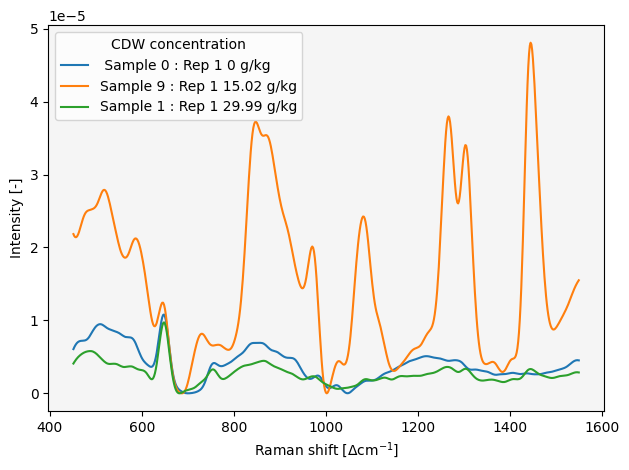

In [22]:
processed_fig, processed_ax = plt.subplots()

lambda_ias = 10
penalty_ias = 1e-4
lambda_der1 = 2e-3
for f in cropped_files:
    s_f = whittaker_smoother_df(f, lambda_smoother, d_smoother)
    #b_f = perform_improved_baseline_correction(f[1], lambda_baseline, lambda1_baseline, p_baseline)
    b_f = improved_asls(s_f, lambda_ias, penalty_ias, lambda_der1)
    #bc_f = s_f -b_f
    #bc_f = s_f - b_f
    processed_ax.plot(f[0], b_f[1])
processed_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
processed_ax.set_ylabel("Intensity [-]")
processed_ax.set_facecolor("whitesmoke")
processed_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 9 : Rep 1 15.02 g/kg", "Sample 1 : Rep 1 29.99 g/kg"], title="CDW concentration")
plt.tight_layout()

## Optimized Preprocessing

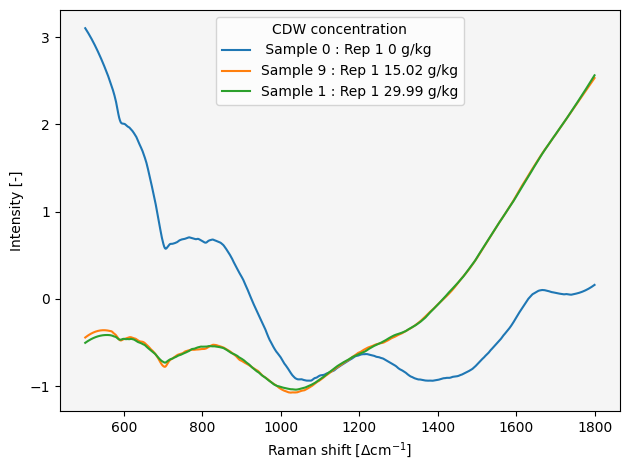

In [23]:
# Vizualization optimize preprocessing
my_data = file_path + "/Export_2D_CDWFat"
#experiment_wanted = '23'
#file_names_spec = triplicata(experiment_wanted,0,my_data,2)
file_names_spec= ['0_254_2D.csv','9_294_2D.csv','1_144_2D.csv']

processed_fig, processed_ax = plt.subplots()

sg_degree = 2
sg_window = 63

lambda_spline_arpls_default =550
knots_arpls_default = 5
spline_deg_arpls_default =2


delete_experiment = []
files,files_names = get_spectra_files(file_path + "/Export_2D_CDWFat/",delete_experiment)
#files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names]

shift_lim = [500, 1800]
cropped_files = [crop_file(f, shift_lim) for f in files]
smoothed_data = [sg_filter(d,sg_degree,sg_window) for d in cropped_files]
bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in smoothed_data]
norm_data = bc_data
norm_data  = snv(bc_data)

for j in file_names_spec:
  for i in range(len(norm_data)):
    if files_names[i] == j:
      processed_ax.plot(norm_data[i][0], norm_data[i][1])


  
processed_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
processed_ax.set_ylabel("Intensity [-]")
processed_ax.set_facecolor("whitesmoke")
#processed_ax.set_ylim(0,0.000022)
#processed_ax.set_ylim(0,0.000052)
#processed_ax.legend(["Sample 5 Rep1: 1.00 g.L-1", "Sample 7 Rep1: 19.99 g.L-1", "Sample 5 Rep2: 1.00 g.L-1", "Sample 7 Rep2: 19.99 g.L-1"],title="fatric Acid Concentration")
#processed_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 7 : Rep 1 9.99 g/kg", "Sample 3 : Rep 1 20.01 g/kg"], title="Fat concentration")
processed_ax.legend([" Sample 0 : Rep 1 0 g/kg", "Sample 9 : Rep 1 15.02 g/kg", "Sample 1 : Rep 1 29.99 g/kg"], title="CDW concentration")
#processed_ax.legend(["Rep 1", "Rep 2", "Rep 3","Rep 4","Rep 5","Rep 6","Rep 7","Rep 8","Rep 9","Rep 10"], title="Sample 23",ncol=2)
plt.tight_layout()

# PLS Regression

## Data preparation 

In [25]:
#file_path = '/content/drive/MyDrive/RamanCDW'
file_path = os.getcwd()
measurement_overview = pd.read_excel(file_path + "/Medium_Cdw_fat.xlsx", sheet_name="Measurements")
training_overview = measurement_overview[measurement_overview["Is for training"] == 1]
testing_overview = measurement_overview[measurement_overview["Is for training"] == 0]


train_file_names = training_overview["File"]
train_concentrations_cdw = training_overview[["Cell dry weight [g/kg]"]]
train_concentrations_fat =  training_overview[["Fat Acid concentration [g/kg]"]]
train_files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in train_file_names]
nb_train = len(train_file_names)

test_file_names = testing_overview["File"]
test_concentrations_cdw = testing_overview[["Cell dry weight [g/kg]"]]
test_concentrations_fat = testing_overview[["Fat Acid concentration [g/kg]"]]
test_files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in test_file_names]
nb_test= len(test_file_names)





In [26]:
##Uncomment This if you want the reference spectra for the msc function

'''
experiment_wanted = '0'
file_names_ref = triplicata(experiment_wanted,0,my_data,2)
files_ref = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names_ref]
'''


'\nexperiment_wanted = \'0\'\nfile_names_ref = triplicata(experiment_wanted,0,my_data,2)\nfiles_ref = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in file_names_ref]\n'

## Raw Data

### No preprocessing

In [27]:
train_raw = [d[1] for d in train_files]
test_raw = [d[1] for d in test_files]

### PLS Model Raw : Building

In [28]:
pls_model_cdw_raw = PLSRegression(n_components=6)
pls_model_cdw_raw.fit(train_raw, train_concentrations_cdw)

pls_model_fat_raw = PLSRegression(n_components=5)
pls_model_fat_raw.fit(train_raw, train_concentrations_fat)



predicted_concentrations_cdw_raw = pls_model_cdw_raw.predict(test_raw)
predicted_concentrations_fat_raw = pls_model_fat_raw.predict(test_raw)



### PLS Model Raw : Predictions

Prediction Raw : cdw

6.578440933564889


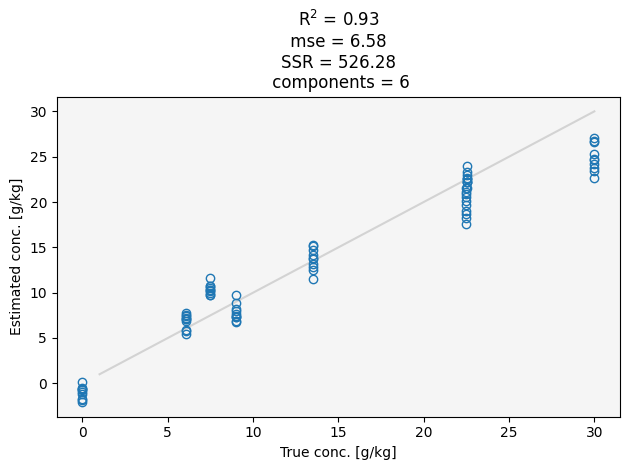

In [83]:
mse = mean_squared_error(predicted_concentrations_cdw_raw,test_concentrations_cdw)
model_score = pls_model_cdw_raw.score(test_raw, test_concentrations_cdw)
residuals = pls_model_cdw_raw.predict(test_raw) - test_concentrations_cdw
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([1,30], [1,30], "-", color="lightgrey")
predict_ax.plot(test_concentrations_cdw.values.T[0], predicted_concentrations_cdw_raw.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_cdw_raw.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

Predictions Raw : fat

24.78788230070218


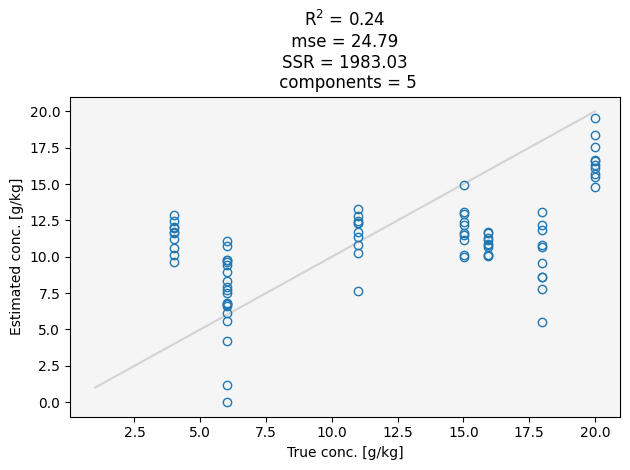

In [85]:
mse = mean_squared_error(predicted_concentrations_fat_raw,test_concentrations_fat)
model_score = pls_model_fat_raw.score(test_raw, test_concentrations_fat)
residuals = pls_model_fat_raw.predict(test_raw) - test_concentrations_fat
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([1,20], [1,20], "-", color="lightgrey")
predict_ax.plot(test_concentrations_fat.values.T[0], predicted_concentrations_fat_raw.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_fat_raw.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

## Reference files preprocessing

In [86]:
#Uncomment if you want to use the ref spectra for reference of the msc function
'''
cropped_file_ref = [crop_file(f, [500, 1800]) for f in files_ref]
smooth_ref = [sg_filter(d,order_smoother,window_smoother) for d in cropped_file_ref]
bc_ref = [amormol(d,23) for d in smooth_ref] 
'''


'\ncropped_file_ref = [crop_file(f, [500, 1800]) for f in files_ref]\nsmooth_ref = [sg_filter(d,order_smoother,window_smoother) for d in cropped_file_ref]\nbc_ref = [amormol(d,23) for d in smooth_ref] \n'

## Unoptimized preprocessed Data

### Unoptimized preprocessing

Parameters for the preprocessing (unoptimized (un))

In [87]:
lambda_smoother = 1000
d_smoother = 3

lambda_baseline = 10
lambda1_baseline = 0.002
p_baseline = 0.0001

Preprocessing the data

In [88]:
train_cropped_data_un = [crop_file(f, [450, 1550]) for f in train_files]
train_smoothed_data_un = [whittaker_smoother_df(d, lambda_smoother, d_smoother) for d in train_cropped_data_un]
train_bc_data_un = [improved_asls(d,lambda_baseline,p_baseline,lambda1_baseline) for d in train_smoothed_data_un]
train_bc_data_un = [d[1] for d in train_bc_data_un]

In [89]:
test_cropped_data_un = [crop_file(f, [450, 1550]) for f in test_files]
test_smoothed_data_un = [whittaker_smoother_df(d, lambda_smoother, d_smoother) for d in test_cropped_data_un]
test_bc_data_un = [improved_asls(d,lambda_baseline,p_baseline,lambda1_baseline) for d in test_smoothed_data_un]
test_bc_data_un = [d[1] for d in test_bc_data_un]


### PLS Model Unoptimized : Building

In [90]:
pls_model_cdw_un = PLSRegression(n_components=9)
pls_model_cdw_un.fit(train_bc_data_un, train_concentrations_cdw)

pls_model_fat_un = PLSRegression(n_components=6)
pls_model_fat_un.fit(train_bc_data_un, train_concentrations_fat)


predicted_concentrations_cdw_un = pls_model_cdw_un.predict(test_bc_data_un)
predicted_concentrations_fat_un = pls_model_fat_un.predict(test_bc_data_un)

### PLS Model Unoptimized : Predictions

Predictions Unoptimized preprocessing : cdw

23.427321356846527


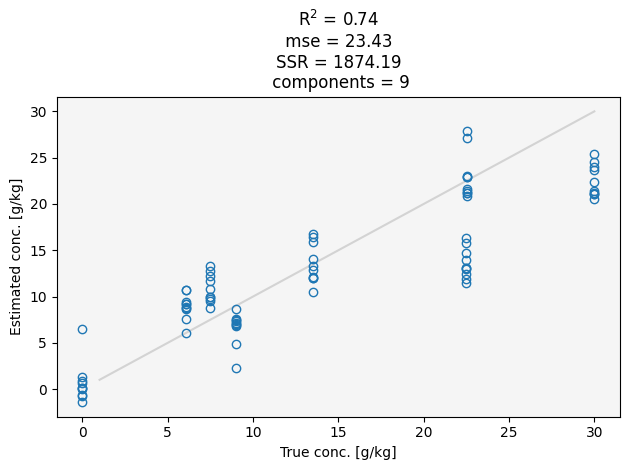

In [91]:
mse = mean_squared_error(predicted_concentrations_cdw_un,test_concentrations_cdw)
model_score = pls_model_cdw_un.score(test_bc_data_un, test_concentrations_cdw)
residuals = pls_model_cdw_un.predict(test_bc_data_un) - test_concentrations_cdw
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([1,30], [1,30], "-", color="lightgrey")
predict_ax.plot(test_concentrations_cdw.values.T[0], predicted_concentrations_cdw_un.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_cdw_un.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

Predictions Unoptimized preprocessing : fat

46.71968046390128


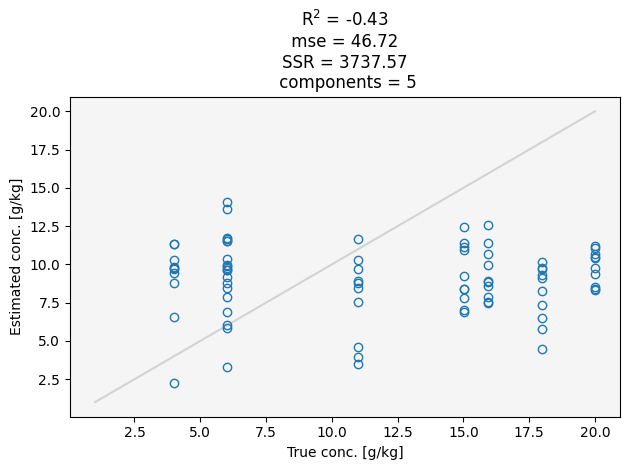

In [92]:
mse = mean_squared_error(predicted_concentrations_fat_un,test_concentrations_fat)
model_score = pls_model_fat_un.score(test_bc_data_un, test_concentrations_fat)
residuals = pls_model_fat_un.predict(test_bc_data_un) - test_concentrations_fat
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([1,20], [1,20], "-", color="lightgrey")
predict_ax.plot(test_concentrations_fat.values.T[0], predicted_concentrations_fat_un.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_fat_raw.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

## Optimized Preprocessed Data

### Optimized preprocessing

Preprocessing parameters

In [93]:
order_smoother = 2
window_smoother = 63

lambda_spline_arpls_default = 550
knots_arpls_default = 5
spline_deg_arpls_default = 2

Preprocessing step

In [94]:

train_cropped_data = [crop_file(f, [500, 1800]) for f in train_files]
train_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in train_cropped_data]
train_bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in train_smoothed_data]
train_raw = [d[1] for d in train_files]


test_cropped_data = [crop_file(f, [500, 1800]) for f in test_files]
test_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in test_cropped_data]
test_bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in test_smoothed_data]
test_bc_data = [d for d in test_bc_data]


X_data = train_bc_data + test_bc_data
X_snv = snv(X_data)
X = [d[1] for d in X_snv] 

nb_train = len(train_bc_data)
train_norm_data = X[0:nb_train]
test_norm_data = X[nb_train:len(X)]




### PLS Model Optimized : Building

In [95]:
pls_model_cdw_opt = PLSRegression(n_components=11)
pls_model_cdw_opt.fit(train_norm_data, train_concentrations_cdw)

pls_model_fat_opt = PLSRegression(n_components=6)
pls_model_fat_opt.fit(train_norm_data, train_concentrations_fat)


predicted_concentrations_cdw_opt = pls_model_cdw_opt.predict(test_norm_data)
predicted_concentrations_fat_opt = pls_model_fat_opt.predict(test_norm_data)


 ### PLS Model Optimized : Predictions

Predictions Optimized preprocessing : cdw

20.351566648816394


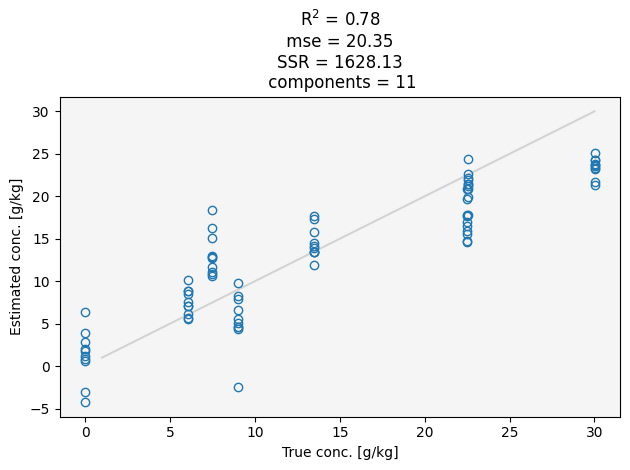

In [96]:
mse = mean_squared_error(predicted_concentrations_cdw_opt,test_concentrations_cdw)
model_score = pls_model_cdw_opt.score(test_norm_data, test_concentrations_cdw)
residuals = pls_model_cdw_opt.predict(test_norm_data) - test_concentrations_cdw
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([1,30], [1,30], "-", color="lightgrey")
predict_ax.plot(test_concentrations_cdw.values.T[0], predicted_concentrations_cdw_opt.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_cdw_opt.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

Predictions Unoptimized preprocessing : fat

44.522487855245444


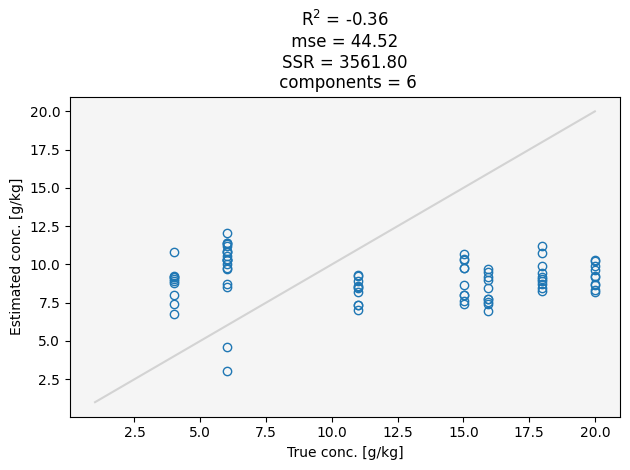

In [97]:
mse = mean_squared_error(predicted_concentrations_fat_opt,test_concentrations_fat)
model_score = pls_model_fat_opt.score(test_norm_data, test_concentrations_fat)
residuals = pls_model_fat_opt.predict(test_norm_data) - test_concentrations_fat
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([1,20], [1,20], "-", color="lightgrey")
predict_ax.plot(test_concentrations_fat.values.T[0], predicted_concentrations_fat_opt.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_fat_opt.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

## CDW With Bioprocess sample

### CDW Bioprocess Sample : Get Real Data 

In [99]:
#file_path_2 = '/content/drive/MyDrive/RamanCDW'
file_path_2 = os.getcwd()
real_files_names = list_files(file_path_2 + "/Bioprocess_2D")
real_files = [pd.read_csv(file_path_2 + "/Bioprocess_2D/" + f, sep="\t", header=None, decimal=",") for f in real_files_names]

real_measurements = pd.read_excel(file_path_2 + "/Real_Measure.xlsx", sheet_name="Measurements")
real_concentrations_cdw = real_measurements[["CDW"]]


### Optimized preprocessing for raw data and for bioprocess samples

Optimized preprocessing parameters

In [100]:
order_smoother = 2
window_smoother = 63

lambda_spline_arpls_default = 550
knots_arpls_default = 5
spline_deg_arpls_default = 2

Perform Optimized preprocessing on train/test and real data

In [101]:
train_cropped_data = [crop_file(f, [500, 1800]) for f in train_files]
train_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in train_cropped_data]
train_bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in train_smoothed_data]


test_cropped_data = [crop_file(f, [500, 1800]) for f in test_files]
test_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in test_cropped_data]
test_bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in test_smoothed_data]
test_bc_data = [d for d in test_bc_data]


real_cropped_data = [crop_file(f, [500, 1800]) for f in real_files]
real_smoothed_data =  [sg_filter(d, order_smoother, window_smoother) for d in real_cropped_data]
real_bc_data_ =  [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in real_smoothed_data]


X_data_real = train_bc_data + test_bc_data + real_bc_data_
X_real = snv(X_data_real)
#X_real = msc(X_data_real,15,bc_ref)

X_r = [d[1] for d in X_real]

print(len(X_r))
nb_train = len(train_bc_data)
nb_test = len(test_bc_data)
train_norm_data_real = X_r[0:nb_train]
test_norm_data_real = X_r[nb_train:(nb_train+nb_test)]
real_norm_data_real = X_r[(nb_train+nb_test):len(X_r)]



530


In [102]:
print(len(test_norm_data_real))
print(len(train_norm_data_real))
print(len(real_norm_data_real))

80
300
150


### PLS Model Real : Building

In [103]:
pls_model_cdw_real = PLSRegression(n_components=11)
pls_model_cdw_real.fit(train_norm_data_real, train_concentrations_cdw)

predicted_concentrations_cdw_real = pls_model_cdw_real.predict(real_norm_data_real)


### PLS Model Real : Predictions

PLS Model Real : cdw

448.19266429255777


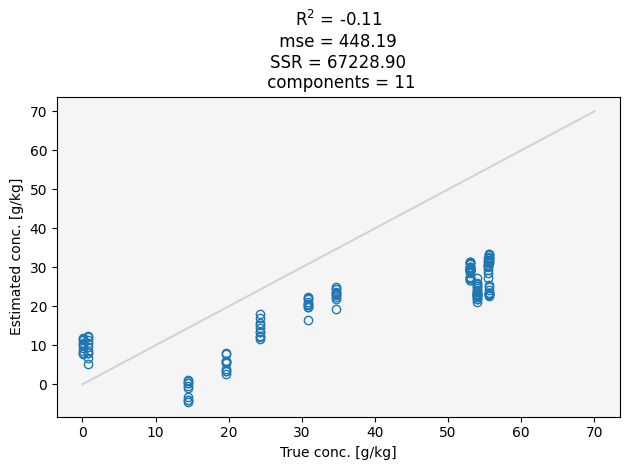

In [104]:
mse = mean_squared_error(predicted_concentrations_cdw_real,real_concentrations_cdw)
model_score = pls_model_cdw_real.score(real_norm_data_real, real_concentrations_cdw)
residuals = pls_model_cdw_real.predict(real_norm_data_real) - real_concentrations_cdw
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([0,70], [0,70], "-", color="lightgrey")
predict_ax.plot(real_concentrations_cdw.values.T[0], predicted_concentrations_cdw_real.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_cdw_real.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

## Fat With Bioprocess sample

### Fat Bioprocess Sample : Get Real Data 

In [29]:
#file_path_2 = '/content/drive/MyDrive/RamanCDW'
file_path_2 = os.getcwd()
real_files_names = list_files(file_path_2 + "/Oil_Measurement_Bioprocess_2D")
real_files = [pd.read_csv(file_path_2 + "/Oil_Measurement_Bioprocess_2D/" + f, sep="\t", header=None, decimal=",") for f in real_files_names]

real_measurements = pd.read_excel(file_path_2 + "/Real_Measure_fat.xlsx", sheet_name="Measurements")
real_concentrations_fat = real_measurements[["Fat"]]


### Optimized preprocessing for raw data and for bioprocess samples

Optimized preprocessing parameters

In [30]:
order_smoother = 2
window_smoother = 63

lambda_spline_arpls_default = 550
knots_arpls_default = 5
spline_deg_arpls_default = 2

Perform Optimized preprocessing on train/test and real data

In [31]:
train_cropped_data = [crop_file(f, [500, 1800]) for f in train_files]
train_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in train_cropped_data]
train_bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in train_smoothed_data]


test_cropped_data = [crop_file(f, [500, 1800]) for f in test_files]
test_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in test_cropped_data]
test_bc_data = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in test_smoothed_data]
test_bc_data = [d for d in test_bc_data]


real_cropped_data = [crop_file(f, [500, 1800]) for f in real_files]
real_smoothed_data =  [sg_filter(d, order_smoother, window_smoother) for d in real_cropped_data]
real_bc_data_ =  [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in real_smoothed_data]


X_data_real = train_bc_data + test_bc_data + real_bc_data_
X_real = snv(X_data_real)
#X_real = msc(X_data_real,15,bc_ref)

X_r = [d[1] for d in X_real]

print(len(X_r))
nb_train = len(train_bc_data)
nb_test = len(test_bc_data)
train_norm_data_real = X_r[0:nb_train]
test_norm_data_real = X_r[nb_train:(nb_train+nb_test)]
real_norm_data_real = X_r[(nb_train+nb_test):len(X_r)]



440


In [32]:
print(len(test_norm_data_real))
print(len(train_norm_data_real))
print(len(real_norm_data_real))

80
300
60


### PLS Model Real : Building

In [33]:
pls_model_fat_real = PLSRegression(n_components=6)
pls_model_fat_real.fit(train_norm_data_real, train_concentrations_fat)

predicted_concentrations_fat_real = pls_model_fat_real.predict(real_norm_data_real)


### PLS Model Real : Predictions

PLS Model Real : fat

47.232185932912266


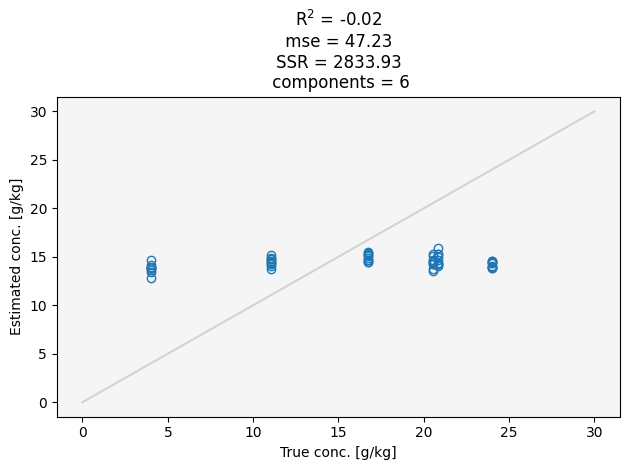

In [34]:
mse = mean_squared_error(predicted_concentrations_fat_real,real_concentrations_fat)
model_score = pls_model_fat_real.score(real_norm_data_real, real_concentrations_fat)
residuals = pls_model_fat_real.predict(real_norm_data_real) - real_concentrations_fat
ssr = sum(sum(residuals.values**2))
print(mse)

predict_fig, predict_ax = plt.subplots()
predict_ax.plot([0,30], [0,30], "-", color="lightgrey")
predict_ax.plot(real_concentrations_fat.values.T[0], predicted_concentrations_fat_real.T[0], "o", fillstyle="none")
predict_ax.set_title("R$^2$ = {:.2f}\n mse = {:.2f} \nSSR = {:.2f}\n components = {}".format(model_score, mse, ssr, pls_model_fat_real.x_weights_.shape[1]))
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")

plt.tight_layout()

# 1D CNN


Deep Learning method using a Convolutional Neuron Network in 1D. (Computer Vision for graph) 

For that part a GPU usage is highly recommended to improve the computational speed of the model training

To Use different model comment the unwanted model /decomment the wanted model for eahc experiment for each raw/preprocessed/unpreprocessed dataset

## Data augmentation function (Not used in MT) // Not optimized function 

In [35]:
'''
def add_noise(X,y_1,y_2,y_3):
  X_inc = []
  y1_inc = []
  y2_inc = [] 
  y3_inc = []  
  for i in range(len(y_1)):
    X_inc.append(X[i])  
    y1_inc.append(y_1[i])
    y2_inc.append(y_2[i])
    y3_inc.append(y_3[i])
    for k in range(5):
      X_aug = []
      for j in range(len(X[i])):
        val = X[i][j]
        rand_i = random.random()/10
        X_aug.append(val + rand_i*val)
      X_inc.append(X_aug)
      y1_inc.append(y_1[i])
      y2_inc.append(y_2[i])
      y3_inc.append(y_3[i])
  X_inc = np.array(X_inc)
  y1_inc = np.array(y1_inc)
  y2_inc = np.array(y2_inc)
  y3_inc = np.array(y3_inc)
    
  return X_inc,y1_inc,y2_inc,y3_inc
  '''

'\ndef add_noise(X,y_1,y_2,y_3):\n  X_inc = []\n  y1_inc = []\n  y2_inc = [] \n  y3_inc = []  \n  for i in range(len(y_1)):\n    X_inc.append(X[i])  \n    y1_inc.append(y_1[i])\n    y2_inc.append(y_2[i])\n    y3_inc.append(y_3[i])\n    for k in range(5):\n      X_aug = []\n      for j in range(len(X[i])):\n        val = X[i][j]\n        rand_i = random.random()/10\n        X_aug.append(val + rand_i*val)\n      X_inc.append(X_aug)\n      y1_inc.append(y_1[i])\n      y2_inc.append(y_2[i])\n      y3_inc.append(y_3[i])\n  X_inc = np.array(X_inc)\n  y1_inc = np.array(y1_inc)\n  y2_inc = np.array(y2_inc)\n  y3_inc = np.array(y3_inc)\n    \n  return X_inc,y1_inc,y2_inc,y3_inc\n  '

## Data preparation

### Access to the file

In [38]:
#file_path = '/content/drive/MyDrive/RamanCDW'
file_path = os.getcwd()
measurement_overview = pd.read_excel(file_path + "/Medium_Cdw_fat.xlsx", sheet_name="Measurements")
training_overview = measurement_overview[measurement_overview["Is for training"] == 1]
testing_overview = measurement_overview[measurement_overview["Is for training"] == 0]


train_file_names = training_overview["File"]
train_concentrations_cdw = training_overview[["Cell dry weight [g/kg]"]]
train_concentrations_fat =  training_overview[["Fat Acid concentration [g/kg]"]]
train_files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in train_file_names]
nb_train = len(train_file_names)

test_file_names = testing_overview["File"]
test_concentrations_cdw = testing_overview[["Cell dry weight [g/kg]"]]
test_concentrations_fat = testing_overview[["Fat Acid concentration [g/kg]"]]
test_files = [pd.read_csv(file_path + "/Export_2D_CDWFat/" + f, sep="\t", header=None, decimal=",") for f in test_file_names]
nb_test= len(test_file_names)

#file_path_2 = '/content/drive/MyDrive/RamanCDW'
file_path_2 = os.getcwd()
real_files_names = list_files(file_path_2 + "/Bioprocess_2D")
real_files = [pd.read_csv(file_path_2 + "/Bioprocess_2D/" + f, sep="\t", header=None, decimal=",") for f in real_files_names]
real_measurements = pd.read_excel(file_path_2 + "/Real_Measure.xlsx", sheet_name="Measurements")
real_concentrations_cdw = real_measurements[["CDW"]]

real_files_names_oil = list_files(file_path_2 + "/Oil_Measurement_Bioprocess_2D")
real_files_oil = [pd.read_csv(file_path_2 + "/Oil_Measurement_Bioprocess_2D/" + f, sep="\t", header=None, decimal=",") for f in real_files_names_oil]

real_measurements_oil = pd.read_excel(file_path_2 + "/Real_Measure_fat.xlsx", sheet_name="Measurements")
real_concentrations_fat = real_measurements_oil[["Fat"]]






### Raw data

In [39]:
train_raw =  train_files
test_raw =  test_files

### Optimized preprocessing

Optimized parameters

In [40]:
order_smoother = 2
window_smoother = 63

lambda_spline_arpls_default = 550
knots_arpls_default = 5
spline_deg_arpls_default = 2

Optimized preprocessing

In [41]:
train_cropped_data = [crop_file(f, [500, 1800]) for f in train_files]
train_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in train_cropped_data]
train_bc_data_ = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in train_smoothed_data]
train_bc_data= [d[1] for d in train_bc_data_]



test_cropped_data = [crop_file(f, [500, 1800]) for f in test_files]
test_smoothed_data = [sg_filter(d,order_smoother,window_smoother) for d in test_cropped_data]
test_bc_data_ = [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in test_smoothed_data]
test_bc_data = [d[1] for d in test_bc_data_]



real_cropped_data = [crop_file(f, [500, 1800]) for f in real_files]
real_smoothed_data =  [sg_filter(d, order_smoother, window_smoother) for d in real_cropped_data]
real_bc_data_ =  [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in real_smoothed_data]

real_cropped_data_oil = [crop_file(f, [500, 1800]) for f in real_files_oil]
real_smoothed_data_oil =  [sg_filter(d, order_smoother, window_smoother) for d in real_cropped_data_oil]
real_bc_data_oil =  [spline_arpls(d, lambda_spline_arpls_default, knots_arpls_default, spline_deg_arpls_default) for d in real_smoothed_data_oil]




### Normalization

In [42]:
X_raw = train_raw + test_raw
X_raw_ = [d[1] for d in X_raw]
X_raw = tf.keras.utils.normalize(X_raw_,axis=0)

X_data = train_bc_data_ + test_bc_data_
X = snv(X_data)
X = snv_col(X)
X = [d[1] for d in X]

X_data_real = X_data + real_bc_data_
X_real = snv_col(X_data_real)
X_r = [d[1] for d in X_real]

X_data_real_oil = X_data + real_bc_data_oil
X_real_oil = snv_col(X_data_real_oil)
X_r_oil = [d[1] for d in X_real_oil]




### Split the data (X,y)

In [43]:
#print(train_bc_data)

train_raw = X_raw[0:nb_train]
test_raw = X_raw[nb_train:len(X)]
X_train_raw = np.array(train_raw)
X_test_raw = np.array(test_raw)

train_opt_data = X[0:nb_train]
test_opt_data = X[nb_train:len(X)]
X_train_preprocessed = np.array(train_opt_data)
X_test_preprocessed = np.array(test_opt_data)
print(len(X_test_preprocessed ))

train_opt_data_r = X_r[0:nb_train]
test_opt_data_r = X_r[nb_train:len(X)]
real_opt_data_r = X_r[len(X):len(X_r)]
X_train_preprocessed_real = np.array(train_opt_data_r)
X_real_preprocessed = np.array(real_opt_data_r)


train_opt_data_r_oil = X_r_oil[0:nb_train]
test_opt_data_r_oil = X_r_oil[nb_train:len(X)]
real_opt_data_r_oil = X_r_oil[len(X):len(X_r_oil)]
X_train_preprocessed_real_oil = np.array(train_opt_data_r_oil)
X_real_preprocessed_oil = np.array(real_opt_data_r_oil)




y_train_cdw= np.array(train_concentrations_cdw)
y_train_fat= np.array(train_concentrations_fat)

y_train_cdw_freal= np.array(train_concentrations_cdw)
y_train_fat_freal= np.array(train_concentrations_fat)

y_train_cdw_freal_oil= np.array(train_concentrations_cdw)
y_train_fat_freal_oil= np.array(train_concentrations_fat)

#Duplicate the y_train for shuffle opt /real experiments separately 

y_test_cdw= np.array(test_concentrations_cdw)
y_test_fat= np.array(test_concentrations_fat)


y_real_cdw =np.array(real_concentrations_cdw)
y_real_fat =np.array(real_concentrations_fat)



print(X_train_preprocessed.shape)

80
(300, 730)


### Final preparation for the ANN

In order to build an ANN, the dimension of the numpy array has to be expand

In [44]:
X_train_raw = np.expand_dims(X_train_raw, axis=2)
X_test_raw = np.expand_dims(X_test_raw, axis=2)

X_train_preprocessed = np.expand_dims(X_train_preprocessed, axis=2)
X_test_preprocessed = np.expand_dims(X_test_preprocessed, axis=2)
#X_train_preprocessed_A = np.expand_dims(X_train_preprocessed_A, axis=2)

X_train_preprocessed_real = np.expand_dims(X_train_preprocessed_real, axis=2)
X_real_preprocessed = np.expand_dims(X_real_preprocessed, axis=2)

X_train_preprocessed_real_oil = np.expand_dims(X_train_preprocessed_real_oil, axis=2)
X_real_preprocessed_oil = np.expand_dims(X_real_preprocessed_oil, axis=2)


In [45]:
print(X_train_preprocessed.shape)
#print(X_train_preprocessed_A.shape)
print(X_train_raw.shape)
print(X_test_preprocessed.shape)
print(X_real_preprocessed.shape)
print(X_real_preprocessed_oil.shape)


(300, 730, 1)
(300, 1431, 1)
(80, 730, 1)
(150, 730, 1)
(60, 730, 1)


### Shuffle the data

In order to perfectly randomize the training, the trianing data are shuffle

In [46]:
from sklearn.utils import shuffle
X_train_preprocessed, X_train_raw, y_train_cdw, y_train_fat = shuffle(X_train_preprocessed,X_train_raw, y_train_cdw, y_train_fat)
#X_train_preprocessed_A, y_train_cdw_A, y_train_fat_A,y_train_amo_A = shuffle(X_train_preprocessed_A, y_train_cdw_A, y_train_fat_A,y_train_amo_A)
X_train_preprocessed_real, y_train_cdw_freal, y_train_fat_freal = shuffle(X_train_preprocessed_real, y_train_cdw_freal, y_train_fat_freal)
X_train_preprocessed_real_oil, y_train_cdw_freal_oil, y_train_fat_freal_oil = shuffle(X_train_preprocessed_real, y_train_cdw_freal_oil, y_train_fat_freal_oil)

In [47]:
print(X_train_preprocessed.shape)

(300, 730, 1)


## CNN Model Building

### CNN Building Non used###

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,BatchNormalization, AveragePooling1D
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import activations

'''


def model_creation_avg (trained):
  """Creation of the a 1D CNN model (simple) with :

    Input layer and Hidden Layer :
    3 x 1D-CNN layer  (Conv1D + MaxPool1D) activation = relu 
    
    Output layer :
    Dense layer with one node linear activation

    Compilation :
    Loss = mean_squared_error
    optimizer = adam
    metrics = root_mean_square_error
    
    Parameters
    ----------
    None
        
    Returns
    -------
    model : Sequencial Type model
        
  """

  model = Sequential()

  model.add(Conv1D(filters=16, kernel_size=7, activation='relu', input_shape = (trained.shape[1], 1)))
  model.add(AveragePooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
  model.add(AveragePooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(AveragePooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(1, activation='linear'))

  

  #opt = tf.keras.optimizers.Adam(learning_rate=4e-3,decay=1e-2)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])

  return model


def model_creation_complex(trained):
  """
  Creation of the a 1D CNN model (complex) with :

  Input layer:
  1D-CNN layer (3 x Conv1D + Maxpool 1D) activation = relu 
  
  Hidden layer :
  1D-CNN layer  (2 x Conv1D + MaxPool1D) activation = relu 
  1D-CNN layer  (1 x Conv1D + MaxPool1D) activation = relu 
  
  Output layer :
  Dense layer with 1 node linear activation

  Compilation :
  Loss = mean_squared_error
  optimizer = adam
  metrics = root_mean_square_error
  
  Parameters
  ----------
  None
      
  Returns
  -------
  model : Sequencial Type model
        
  """
  print(trained.shape[1])
  model = Sequential()

  model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape = (trained.shape[1], 1)))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.5))



  model.add(Flatten())
  model.add(Dense(1, activation='linear'))

  

  #opt = tf.keras.optimizers.Adam(learning_rate=4e-3,decay=1e-2)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])
  return model

  



def model_creation_vgg4(trained):
  """
  Creation of the a 1D CNN model (complex) with :

  Input layer:
  1D-CNN layer (3 x Conv1D + Maxpool 1D) activation = relu 
  
  Hidden layer :
  1D-CNN layer  (2 x Conv1D + MaxPool1D) activation = relu 
  1D-CNN layer  (1 x Conv1D + MaxPool1D) activation = relu 
  
  Output layer :
  Dense layer with 1 node linear activation

  Compilation :
  Loss = mean_squared_error
  optimizer = adam
  metrics = root_mean_square_error
  
  Parameters
  ----------
  None
      
  Returns
  -------
  model : Sequencial Type model
        
  """
  print(trained.shape[1])
  model = Sequential()

  model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape = (trained.shape[1], 1)))
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=4,padding = 'same'))
  model.add(Dropout(0.1))

  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=4,padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=4,padding = 'same'))
  model.add(Dropout(0.3))

  model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=1024, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=4,padding = 'same'))
  model.add(Dropout(0.4))


  model.add(Flatten())


  
  model.add(Dense(512))

  model.add(Dense(1, activation='linear'))

  

  #opt = tf.keras.optimizers.Adam(learning_rate=5e-3,decay=1e-3)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])
  return model
'''

'\n\n\ndef model_creation_avg (trained):\n  """Creation of the a 1D CNN model (simple) with :\n\n    Input layer and Hidden Layer :\n    3 x 1D-CNN layer  (Conv1D + MaxPool1D) activation = relu \n    \n    Output layer :\n    Dense layer with one node linear activation\n\n    Compilation :\n    Loss = mean_squared_error\n    optimizer = adam\n    metrics = root_mean_square_error\n    \n    Parameters\n    ----------\n    None\n        \n    Returns\n    -------\n    model : Sequencial Type model\n        \n  """\n\n  model = Sequential()\n\n  model.add(Conv1D(filters=16, kernel_size=7, activation=\'relu\', input_shape = (trained.shape[1], 1)))\n  model.add(AveragePooling1D(pool_size=2,padding = \'same\'))\n  model.add(Conv1D(filters=32, kernel_size=7, activation=\'relu\'))\n  model.add(AveragePooling1D(pool_size=2,padding = \'same\'))\n  model.add(Conv1D(filters=64, kernel_size=5, activation=\'relu\'))\n  model.add(Conv1D(filters=256, kernel_size=3, activation=\'relu\'))\n  model.add(A

### CNN Building Used

In [49]:
def model_creation_standard_with_bn(trained):
  """Creation of the a 1D CNN model (simple) with :

    Input layer and Hidden Layer :
    3 x 1D-CNN layer  (Conv1D + MaxPool1D) activation = relu 
    
    Output layer :
    Dense layer with one node linear activation

    Compilation :
    Loss = mean_squared_error
    optimizer = adam
    metrics = root_mean_square_error
    
    Parameters
    ----------
    None
        
    Returns
    -------
    model : Sequencial Type model
        
  """

  model = Sequential()

  model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape = (trained.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  



  model.add(Flatten())
  model.add(Dense(100))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='linear'))

  

  #opt = tf.keras.optimizers.Adam(learning_rate=4e-3,decay=1e-2)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])

  return model


In [50]:
def model_creation_bottleneck(trained):
  """
  Creation of the a 1D CNN model (complex) with :

  Input layer:
  1D-CNN layer (2 x Conv1D + Maxpool 1D) activation = relu + Dropout(0.4)
  
  Hidden layer :
  1D-CNN layer  (2 x Conv1D + MaxPool1D) activation = relu  + Dropout(0.4)
  1D-CNN layer  (1 x Conv1D + MaxPool1D) activation = relu + Dropout(0.4)
  
  Output layer :
  Dense layer with 1 node linear activation

  Compilation :
  Loss = mean_squared_error
  optimizer = adam
  metrics = root_mean_square_error
  learning = early_stopping
  
  Parameters
  ----------
  None
      
  Returns
  -------
  model : Sequencial Type model
        
  """
  print(trained.shape[1])
  model = Sequential()

  model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape = (trained.shape[1], 1)))
  model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.4))

  model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
  model.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.4))

  model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.4))

  model.add(Flatten())
  

  model.add(Dense(1, activation='linear'))

  #opt = tf.keras.optimizers.Adam(learning_rate=5e-3,decay=1e-3)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])
  return model



In [51]:
def model_creation_regress(trained): #CNN Bottleneck with regressor
  """
  Creation of the a 1D CNN model (complex) with :

  Input layer:
  1D-CNN layer (3 x Conv1D + Maxpool 1D) activation = relu
  
  Hidden layer :
  (Convolutional)
  1D-CNN layer  (2 x Conv1D + MaxPool1D) activation = relu 
  1D-CNN layer  (1 x Conv1D + MaxPool1D) activation = relu 
  (Regressor)
  Dense Layer (3 x FC layer) activation = relu
  Dense Layer (1 x FC layer)

  Output layer :
  Dense layer with 1 node linear activation

  Compilation :
  Loss = mean_squared_error
  optimizer = adam
  metrics = root_mean_square_error
  learning = early_stopping
  
  Parameters
  ----------
  None
      
  Returns
  -------
  model : Sequencial Type model
        
  """

  model = Sequential()

  model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape = (trained.shape[1], 1)))
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.5))




  model.add(Flatten())
  model.add(Dense(64,activation = 'relu'))
  model.add(Dense(64,activation = 'relu'))
  model.add(Dense(64,activation = 'relu'))
  model.add(Dense(10))
  model.add(Dense(1, activation='linear'))

  

  #opt = tf.keras.optimizers.Adam(learning_rate=4e-3,decay=1e-2)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])

  return model

In [52]:
def model_creation_regress_simple(trained): #CNN Bottleneck simplified with regressor and SeLU activation function
  """
  Creation of the a 1D CNN model (complex) with :

  Input layer:
  1D-CNN layer (3 x Conv1D + Maxpool 1D) activation = selu
  
  Hidden layer :
  (Convolutional)
  1D-CNN layer  (2 x Conv1D + MaxPool1D) activation = selu 
  1D-CNN layer  (1 x Conv1D + MaxPool1D) activation = selu 
  (Regressor)
  Dense Layer (3 x FC layer) activation = selu
  Dense Layer (1 x FC layer)

  Output layer :
  Dense layer with 1 node linear activation

  Compilation :
  Loss = mean_squared_error
  optimizer = adam
  metrics = root_mean_square_error
  learning = early_stopping
  
  Parameters
  ----------
  None
      
  Returns
  -------
  model : Sequencial Type model
        
  """

  model = Sequential()

  model.add(Conv1D(filters=4, kernel_size=3, activation='selu', input_shape = (trained.shape[1], 1)))
  model.add(Conv1D(filters=8, kernel_size=3, activation='selu'))
  model.add(Conv1D(filters=16, kernel_size=3, activation='selu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=8, kernel_size=3, activation='selu'))
  model.add(Conv1D(filters=16, kernel_size=3, activation='selu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Conv1D(filters=16, kernel_size=3, activation='selu'))
  model.add(MaxPooling1D(pool_size=2,padding = 'same'))
  model.add(Dropout(0.6))




  model.add(Flatten())
  model.add(Dense(32,activation = 'selu'))
  model.add(Dense(32,activation = 'selu'))
  model.add(Dense(32,activation = 'selu'))
  model.add(Dropout(0.1))
  model.add(Dense(10))
  
  model.add(Dense(1, activation='linear'))

  

  #opt = tf.keras.optimizers.Adam(learning_rate=4e-3,decay=1e-2)

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])

  return model

## CNN Model Fitting Raw Data

### CDW regression

For all the training : the model is early stopped to prevent over fitting with a patience monitored on val_loss.

In [179]:
model_cdw_raw = model_creation_standard_with_bn(X_train_raw)
#model_cdw_raw = model_creation_bottleneck(X_train_raw)
#model_cdw_raw = model_creation_regress(X_train_raw)
#model_cdw_raw = model_creation_regress_simple(X_train_raw)
print(model_cdw_raw)
early_stop = EarlyStopping(monitor='val_loss',patience=750,restore_best_weights=False,verbose=1)
cdw_model_history_raw =  model_cdw_raw.fit(X_train_raw,y_train_cdw,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
8/8 [==============================] - 9s 49ms/step - loss: 257.3544 - root_mean_squared_error: 16.0423 - val_loss: 232.3255 - val_root_mean_squared_error: 15.2422
Epoch 2/2000
8/8 [==============================] - 0s 9ms/step - loss: 245.0392 - root_mean_squared_error: 15.6537 - val_loss: 234.3298 - val_root_mean_squared_error: 15.3078
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 240.9284 - root_mean_squared_error: 15.5219 - val_loss: 245.3951 - val_root_mean_squared_error: 15.6651
Epoch 4/2000
8/8 [==============================] - 0s 8ms/step - loss: 234.3695 - root_mean_squared_error: 15.3091 - val_loss: 227.7807 - val_root_mean_squared_error: 15.0924
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 231.7981 - root_mean_squared_error: 15.2249 - val_loss: 233.9222 - val_root_mean_squared_error: 15.2945
Epoch 6/2000
8/8 [==============================] - 0s 9ms/step - loss: 228.7531 - root_mean_squared_error: 15.1246 - v

Training/ Validation loss

In [182]:
print(min(cdw_model_history_raw.history['loss']))
print(min(cdw_model_history_raw.history['val_loss']))
j = cdw_model_history_raw.history['val_loss'].index(min(cdw_model_history_raw.history['val_loss']))
print(cdw_model_history_raw.history['loss'][j])

0.17179618775844574
3.639643430709839
2.946516752243042


Predictions

3/3 [==============================] - 0s 8ms/step
66.13533489557551
[5290.82679165]


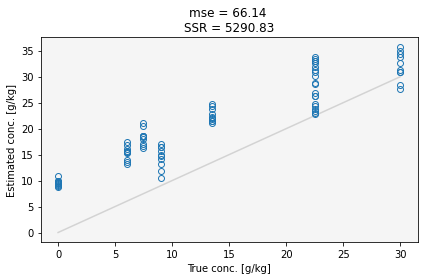

In [184]:
predicted_concentrations_raw_cdw = model_cdw_raw.predict(X_test_raw)

res = []
for i in range(len(y_test_cdw)):
  residuals = (predicted_concentrations_raw_cdw[i] - y_test_cdw[i])**2
  res.append(residuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_concentrations_raw_cdw,y_test_cdw)
print(mse)

ssr =sum(res)
print(ssr)

predict_fig, predict_ax = plt.subplots()

predict_ax.plot([0,30], [0,30], "-", color="lightgrey")
predict_ax.plot(y_test_cdw, predicted_concentrations_raw_cdw, "o", fillstyle="none")
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")
predict_ax.set_title("mse = {:.2f} \nSSR = {:.2f}".format(mse, ssr[0]))

plt.tight_layout()

### Fat regression

In [185]:
model_fat_raw = model_creation_standard_with_bn(X_train_raw)
#model_fat_raw = model_creation_bottleneck(X_train_raw)
#model_fat_raw = model_creation_regress(X_train_raw)
#model_fat_raw = model_creation_regress_simple(X_train_raw)
print(model_fat_raw)
early_stop = EarlyStopping(monitor='val_loss',patience=750,restore_best_weights=False,verbose=1)
fat_model_history_raw =  model_fat_raw.fit(X_train_raw,y_train_fat,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
8/8 [==============================] - 1s 33ms/step - loss: 143.8683 - root_mean_squared_error: 11.9945 - val_loss: 114.2896 - val_root_mean_squared_error: 10.6906
Epoch 2/2000
8/8 [==============================] - 0s 8ms/step - loss: 133.4163 - root_mean_squared_error: 11.5506 - val_loss: 109.7453 - val_root_mean_squared_error: 10.4759
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 131.6802 - root_mean_squared_error: 11.4752 - val_loss: 111.0370 - val_root_mean_squared_error: 10.5374
Epoch 4/2000
8/8 [==============================] - 0s 11ms/step - loss: 128.7891 - root_mean_squared_error: 11.3485 - val_loss: 111.4396 - val_root_mean_squared_error: 10.5565
Epoch 5/2000
8/8 [==============================] - 0s 9ms/step - loss: 127.7442 - root_mean_squared_error: 11.3024 - val_loss: 107.6730 - val_root_mean_squared_error: 10.3766
Epoch 6/2000
8/8 [==============================] - 0s 9ms/step - loss: 124.6995 - root_mean_squared_error: 11.1669 - 

In [186]:
print(min(fat_model_history_raw.history['loss']))
print(min(fat_model_history_raw.history['val_loss']))
j = fat_model_history_raw.history['val_loss'].index(min(fat_model_history_raw.history['val_loss']))
print(fat_model_history_raw.history['loss'][j])

0.07391311973333359
20.108888626098633
21.387651443481445


3/3 [==============================] - 0s 4ms/step
44.56458499569572
[3565.16679966]


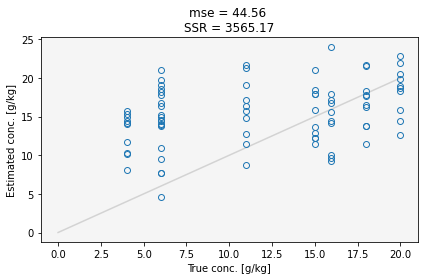

In [187]:
predicted_concentrations_raw_fat = model_fat_raw.predict(X_test_raw)

res = []
for i in range(len(y_test_fat)):
  residuals = (predicted_concentrations_raw_fat[i] - y_test_fat[i])**2
  res.append(residuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_concentrations_raw_fat,y_test_fat)
print(mse)

ssr =sum(res)
print(ssr)

predict_fig, predict_ax = plt.subplots()

predict_ax.plot([0,20], [0,20], "-", color="lightgrey")
predict_ax.plot(y_test_fat, predicted_concentrations_raw_fat, "o", fillstyle="none")
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")
predict_ax.set_title("mse = {:.2f} \nSSR = {:.2f}".format(mse, ssr[0]))

plt.tight_layout()

## CNN Model Fitting Optimized prerpocessed data

### Cdw regression

In [188]:
model_cdw_preprocessed = model_creation_standard_with_bn(X_train_preprocessed)
#model_cdw_preprocessed = model_creation_bottleneck(X_train_preprocessed)
#model_cdw_preprocessed = model_creation_regress(X_train_preprocessed)
#model_cdw_preprocessed = model_creation_regress_simple(X_train_preprocessed)
print(model_cdw_preprocessed)
early_stop = EarlyStopping(monitor='val_loss',patience=750,restore_best_weights=False,verbose=1)
cdw_model_history_preprocessed =  model_cdw_preprocessed.fit(X_train_preprocessed,y_train_cdw,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
8/8 [==============================] - 1s 54ms/step - loss: 270.9892 - root_mean_squared_error: 16.4617 - val_loss: 312.4869 - val_root_mean_squared_error: 17.6773
Epoch 2/2000
8/8 [==============================] - 0s 8ms/step - loss: 257.7880 - root_mean_squared_error: 16.0558 - val_loss: 315.3399 - val_root_mean_squared_error: 17.7578
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 248.8302 - root_mean_squared_error: 15.7744 - val_loss: 315.2806 - val_root_mean_squared_error: 17.7561
Epoch 4/2000
8/8 [==============================] - 0s 8ms/step - loss: 244.2651 - root_mean_squared_error: 15.6290 - val_loss: 316.7747 - val_root_mean_squared_error: 17.7982
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 238.1738 - root_mean_squared_error: 15.4329 - val_loss: 318.1092 - val_root_mean_squared_error: 17.8356
Epoch 6/2000
8/8 [==============================] - 0s 7ms/step - loss: 235.2629 - root_mean_squared_error: 15.3383 - v

In [189]:
print(min(cdw_model_history_preprocessed.history['loss']))
print(min(cdw_model_history_preprocessed.history['val_loss']))
j = cdw_model_history_preprocessed.history['val_loss'].index(min(cdw_model_history_preprocessed.history['val_loss']))
print(cdw_model_history_preprocessed.history['loss'][j])

0.4849243462085724
8.913639068603516
4.395701885223389


3/3 [==============================] - 0s 4ms/step
19.390672024986095
[1551.253762]


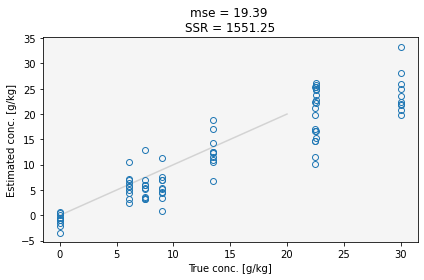

In [190]:
predicted_concentrations_preprocessed_cdw = model_cdw_preprocessed.predict(X_test_preprocessed)

res = []
for i in range(len(y_test_cdw)):
  residuals = (predicted_concentrations_preprocessed_cdw[i] - y_test_cdw[i])**2
  res.append(residuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_concentrations_preprocessed_cdw,y_test_cdw)
print(mse)

ssr =sum(res)
print(ssr)

predict_fig, predict_ax = plt.subplots()

predict_ax.plot([0,30], [0,30], "-", color="lightgrey")
predict_ax.plot(y_test_cdw, predicted_concentrations_preprocessed_cdw, "o", fillstyle="none")
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")
predict_ax.set_title("mse = {:.2f} \nSSR = {:.2f}".format(mse, ssr[0]))

plt.tight_layout()

### Fat regression

In [191]:
model_fat_preprocessed = model_creation_standard_with_bn(X_train_preprocessed)
#model_fat_preprocessed = model_creation_bottleneck(X_train_preprocessed)
#model_fat_preprocessed = model_creation_regress(X_train_preprocessed)
#model_fat_preprocessed = model_creation_regress_simple(X_train_preprocessed)
print(model_fat_preprocessed)
early_stop = EarlyStopping(monitor='val_loss',patience=750,restore_best_weights=False,verbose=1)
fat_model_history_preprocessed =  model_fat_preprocessed.fit(X_train_preprocessed,y_train_fat,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
8/8 [==============================] - 1s 32ms/step - loss: 139.2622 - root_mean_squared_error: 11.8009 - val_loss: 114.9854 - val_root_mean_squared_error: 10.7231
Epoch 2/2000
8/8 [==============================] - 0s 8ms/step - loss: 129.4852 - root_mean_squared_error: 11.3792 - val_loss: 120.1516 - val_root_mean_squared_error: 10.9614
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 125.9326 - root_mean_squared_error: 11.2220 - val_loss: 119.0542 - val_root_mean_squared_error: 10.9112
Epoch 4/2000
8/8 [==============================] - 0s 8ms/step - loss: 123.2326 - root_mean_squared_error: 11.1010 - val_loss: 117.0463 - val_root_mean_squared_error: 10.8188
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 120.1641 - root_mean_squared_error: 10.9619 - val_loss: 117.2026 - val_root_mean_squared_error: 10.8260
Epoch 6/2000
8/8 [==============================] - 0s 8ms/step - loss: 116.8164 - root_mean_squared_error: 10.8082 - v

In [192]:
print(min(fat_model_history_raw.history['loss']))
print(min(fat_model_history_raw.history['val_loss']))
j = fat_model_history_raw.history['val_loss'].index(min(fat_model_history_raw.history['val_loss']))
print(fat_model_history_raw.history['loss'][j])

0.07391311973333359
20.108888626098633
21.387651443481445


3/3 [==============================] - 0s 4ms/step
83.70292336996661
[6696.2338696]


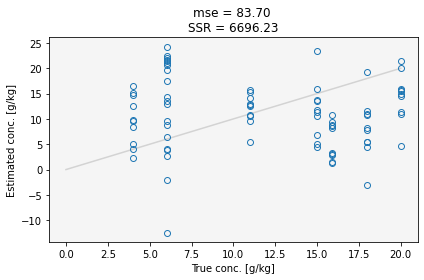

In [193]:
predicted_concentrations_preprocessed_fat = model_fat_preprocessed.predict(X_test_preprocessed)

res = []
for i in range(len(y_test_fat)):
  residuals = (predicted_concentrations_preprocessed_fat[i] - y_test_fat[i])**2
  res.append(residuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_concentrations_preprocessed_fat,y_test_fat)
print(mse)

ssr =sum(res)
print(ssr)

predict_fig, predict_ax = plt.subplots()

predict_ax.plot([0,20], [0,20], "-", color="lightgrey")
predict_ax.plot(y_test_fat, predicted_concentrations_preprocessed_fat, "o", fillstyle="none")
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")
predict_ax.set_title("mse = {:.2f} \nSSR = {:.2f}".format(mse, ssr[0]))

plt.tight_layout()

## CNN Model Fiiting with Real Bioprocess data

### cdw regression

In [216]:
model_cdw_real = model_creation_standard_with_bn(X_train_preprocessed_real)
#model_cdw_real = model_creation_bottleneck(X_train_preprocessed)
#model_cdw_real= model_creation_regress(X_train_preprocessed)
#model_cdw_real = model_creation_regress_simple(X_train_preprocessed)
print(model_cdw_real)
early_stop = EarlyStopping(monitor='val_loss',patience=750,restore_best_weights=False,verbose=1)
cdw_model_history_real =  model_cdw_real.fit(X_train_preprocessed_real,y_train_cdw_freal,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
8/8 [==============================] - 1s 34ms/step - loss: 248.8539 - root_mean_squared_error: 15.7751 - val_loss: 341.3344 - val_root_mean_squared_error: 18.4752
Epoch 2/2000
8/8 [==============================] - 0s 8ms/step - loss: 237.8387 - root_mean_squared_error: 15.4220 - val_loss: 349.3556 - val_root_mean_squared_error: 18.6911
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 229.9445 - root_mean_squared_error: 15.1639 - val_loss: 358.8475 - val_root_mean_squared_error: 18.9433
Epoch 4/2000
8/8 [==============================] - 0s 8ms/step - loss: 226.1268 - root_mean_squared_error: 15.0375 - val_loss: 359.8522 - val_root_mean_squared_error: 18.9698
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 223.7721 - root_mean_squared_error: 14.9590 - val_loss: 349.4214 - val_root_mean_squared_error: 18.6928
Epoch 6/2000
8/8 [==============================] - 0s 9ms/step - loss: 217.6568 - root_mean_squared_error: 14.7532 - v

5/5 [==============================] - 0s 3ms/step
292.3602409530083
[43854.03614295]


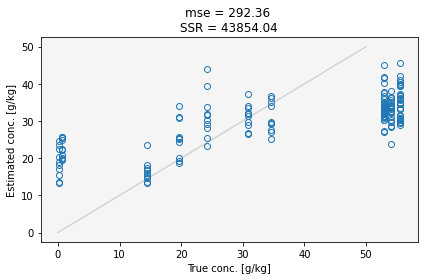

In [217]:
predicted_concentrations_real_cdw = model_cdw_real.predict(X_real_preprocessed)

res = []
for i in range(len(y_real_cdw)):
  residuals = (predicted_concentrations_real_cdw[i] - y_real_cdw[i])**2
  res.append(residuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_concentrations_real_cdw,y_real_cdw)
print(mse)

ssr =sum(res)
print(ssr)

predict_fig, predict_ax = plt.subplots()

predict_ax.plot([0,50], [0,50], "-", color="lightgrey")
predict_ax.plot(y_real_cdw, predicted_concentrations_real_cdw, "o", fillstyle="none")
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")
predict_ax.set_title("mse = {:.2f} \nSSR = {:.2f}".format(mse, ssr[0]))

plt.tight_layout()

### Fat regression

In [214]:
model_fat_real = model_creation_standard_with_bn(X_train_preprocessed_real_oil)
#model_fat_real = model_creation_bottleneck(X_train_preprocessed)
#model_fat_real= model_creation_regress(X_train_preprocessed)
#model_fat_real = model_creation_regress_simple(X_train_preprocessed)
print(model_fat_real)
early_stop = EarlyStopping(monitor='val_loss',patience=750,restore_best_weights=False,verbose=1)
fat_model_history_real =  model_fat_real.fit(X_train_preprocessed_real,y_train_fat_freal_oil,validation_split=0.2,epochs=2000,callbacks=[early_stop])

Epoch 1/2000
8/8 [==============================] - 1s 30ms/step - loss: 137.5226 - root_mean_squared_error: 11.7270 - val_loss: 135.4837 - val_root_mean_squared_error: 11.6397
Epoch 2/2000
8/8 [==============================] - 0s 9ms/step - loss: 130.8691 - root_mean_squared_error: 11.4398 - val_loss: 137.8025 - val_root_mean_squared_error: 11.7389
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 127.3134 - root_mean_squared_error: 11.2833 - val_loss: 134.0386 - val_root_mean_squared_error: 11.5775
Epoch 4/2000
8/8 [==============================] - 0s 8ms/step - loss: 124.8090 - root_mean_squared_error: 11.1718 - val_loss: 133.1870 - val_root_mean_squared_error: 11.5407
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 122.6154 - root_mean_squared_error: 11.0732 - val_loss: 131.8551 - val_root_mean_squared_error: 11.4828
Epoch 6/2000
8/8 [==============================] - 0s 8ms/step - loss: 119.8620 - root_mean_squared_error: 10.9481 - v

2/2 [==============================] - 0s 6ms/step
114.39504182209787
[6863.70250933]


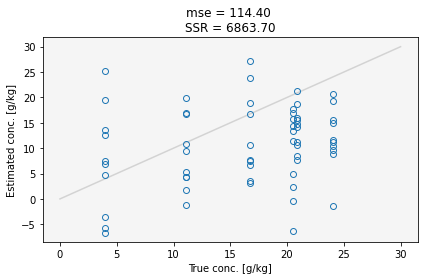

In [215]:
predicted_concentrations_real_fat = model_fat_real.predict(X_real_preprocessed_oil)

res = []
for i in range(len(y_real_fat)):
  residuals = (predicted_concentrations_real_fat[i] - y_real_fat[i])**2
  res.append(residuals)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_concentrations_real_fat,y_real_fat)
print(mse)

ssr =sum(res)
print(ssr)

predict_fig, predict_ax = plt.subplots()

predict_ax.plot([0,30], [0,30], "-", color="lightgrey")
predict_ax.plot(y_real_fat, predicted_concentrations_real_fat, "o", fillstyle="none")
predict_ax.set_xlabel("True conc. [g/kg]")
predict_ax.set_ylabel("Estimated conc. [g/kg]")
predict_ax.set_facecolor("whitesmoke")
predict_ax.set_title("mse = {:.2f} \nSSR = {:.2f}".format(mse, ssr[0]))

plt.tight_layout()

## Learning curve visualization

Vizualise the training and the validation loss through the epochs during the training 

In [ ]:
def plot_LC_loss(model_history):
  '''
  Plot the loss during the training of the 4 models
  ----
  input : 
  
  model_history : vector of the training history of one CNN model
  ----

  output :

  None
  '''
  i_=0
  k=0
  plt.rcParams['figure.figsize'] = (12.0, 7.0)
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'validation'], loc='upper left')
  i_ += 1
  k=k+1

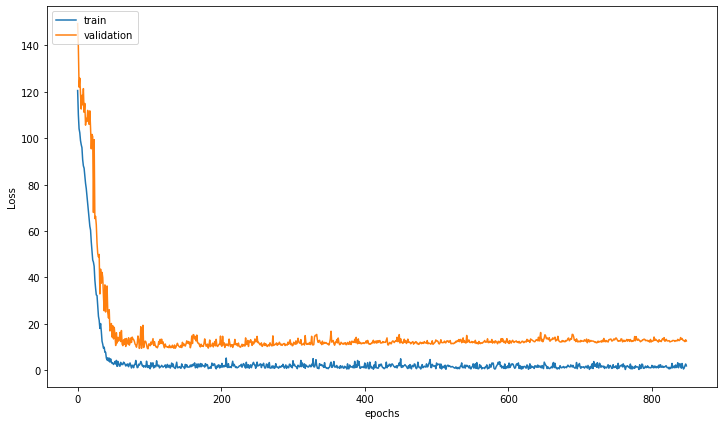

In [ ]:
plot_LC_loss(fat_model_history_real)